In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv
/kaggle/input/copinghard/Processed Disorders.csv


In [2]:
import tensorflow as tf
import keras
from keras import layers
from keras import ops
from keras.optimizers import Adam
from keras_hub.tokenizers import compute_word_piece_vocabulary, WordPieceTokenizer
from keras_hub.layers import TokenAndPositionEmbedding
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df1 = pd.read_csv('/kaggle/input/copinghard/Processed Disorders.csv')
df2 = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')


In [5]:
if df1.isna().any().any(): print("DF1")
if df2.isna().any().any(): print("DF2")

DF2


In [6]:
df1['content'] = df1['content'].apply(lambda text: text.replace('\n', ''))

In [7]:
df2 = df2.dropna()
df2 = df2.drop(columns=['Unnamed: 0'], axis=1)

In [8]:
df2['status'] = df2['status'].apply(lambda x: x.lower())

In [9]:
df2 = df2[df2['status'] == 'normal']

In [10]:
df2 = df2.rename(columns={"status" : "label", "statement" : "content"})

In [11]:
df = pd.concat([df1, df2], axis=0, ignore_index=True)

In [12]:
classes = df['label'].unique()
ordinal = {label: i for i,label in enumerate(classes)}
df['label'] = df['label'].apply(lambda label: ordinal[label])
df = df[df['content'].apply(len) <= 512]

In [13]:
df.head()

,content,label
0,life is so pointless without others : does any...,0
15,it hurts : it fucking hurtsit hurts it hurts i...,0
17,different between attachment and love : the ot...,0
22,what is the point of living when you have no o...,0
31,what kind of people do you find yourself attra...,0


In [14]:
train_df, other = train_test_split(
    df,
    test_size = 0.20,
    random_state = 96,
    stratify = df['label']
)
val_df, test_df = train_test_split(
    other,
    test_size = 0.60,
    random_state = 96,
    stratify = other['label']
)

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_df['content'].values, train_df['label'].values
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    val_df['content'].values, val_df['label'].values
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    test_df['content'].values, test_df['label'].values
))

In [16]:
auto = tf.data.AUTOTUNE
MAX_SEQLEN = 512

In [17]:
BATCH_SIZE = 128
train_dataset = train_dataset.batch(BATCH_SIZE, num_parallel_calls=auto)
val_dataset = val_dataset.batch(BATCH_SIZE, num_parallel_calls=auto)
test_dataset = test_dataset.batch(BATCH_SIZE, num_parallel_calls=auto)

In [18]:
def train_word_piece(ds, vocab_size=64000, reserved_tokens=["[PAD]", "[UNK]"]):
    word_piece = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece.batch(1024).prefetch(4),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens
    )
    return vocab


In [19]:
VOCAB = train_word_piece(train_dataset)

In [20]:
print("Tokens: ", VOCAB[290:310])

Tokens:  ['only', 'hate', 'then', 'make', 'always', 'work', 'back', 'everything', 'take', 'depression', 'better', 'got', 'after', 'way', 'anxious', 'still', 'friends', 'stop', 'she', 'getting']


In [21]:
tokenizer = WordPieceTokenizer(
    vocabulary=VOCAB,
    lowercase=False,
    sequence_length=MAX_SEQLEN
)

In [22]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=auto)
    return dataset.shuffle(1024).prefetch(16).cache()

In [23]:
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [24]:
VOCAB_SIZE = 64000
EMBED_DIM = 128

In [25]:
def SimpleRNN():
    inputs = layers.Input(shape=(MAX_SEQLEN,), dtype="int", name="input_ids")
    x = TokenAndPositionEmbedding(
        vocabulary_size=VOCAB_SIZE,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero = False,
    )(inputs)
    x = layers.Bidirectional(layers.LSTM(units = MAX_SEQLEN, seed=116, return_sequences=True))(x)
    x - layers.LayerNormalization(epsilon=1e-12)(x)
    x = layers.Bidirectional(layers.LSTM(units=MAX_SEQLEN//2, seed=116,))(x)
    x = layers.Dropout(0.10)(x)
    x = layers.Dense(64, activation='gelu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="Xianglin")
    

In [26]:
Xianglin = SimpleRNN()
Xianglin.summary()

Model: "Xianglin"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 512, 128)            │       8,257,536 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 512, 1024)           │       2,625,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 512)                 │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,539,782 (51.65 MB)

 Trainable params: 13,539,782 (51.65 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
earlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=3,
)

modelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'xianglin.keras',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="auto",
    save_freq="epoch",
)

In [28]:
Xianglin.compile(
    optimizer = Adam(learning_rate=0.0007), 
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [29]:
history = Xianglin.fit(train_dataset, epochs=12, validation_data=val_dataset, callbacks=[earlyStopping])

Epoch 1/12
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 1279s 899ms/step - accuracy: 0.6758 - loss: 0.8453 - val_accuracy: 0.8044 - val_loss: 0.5586
Epoch 2/12
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 1267s 897ms/step - accuracy: 0.8137 - loss: 0.5330 - val_accuracy: 0.8063 - val_loss: 0.5443
Epoch 3/12
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 1268s 898ms/step - accuracy: 0.8326 - loss: 0.4819 - val_accuracy: 0.8095 - val_loss: 0.5470
Epoch 4/12
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 1268s 898ms/step - accuracy: 0.8456 - loss: 0.4443 - val_accuracy: 0.8066 - val_loss: 0.5717
Epoch 5/12
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 1269s 899ms/step - accuracy: 0.8591 - loss: 0.4071 - val_accuracy: 0.8025 - val_loss: 0.6107
Epoch 6/12
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 1269s 899ms/step - accuracy: 0.8757 - loss: 0.3670 - val_accuracy: 0.7990 - val_loss: 0.6522
Epoch 7/12
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 1271s 900ms/step - accuracy: 0.8886 - loss: 0.3286 - val_accuracy: 0.7950 - val_loss: 0.7129
Epoch 7: early stopping
Restoring model weights from th

In [33]:
import matplotlib.pyplot as plt

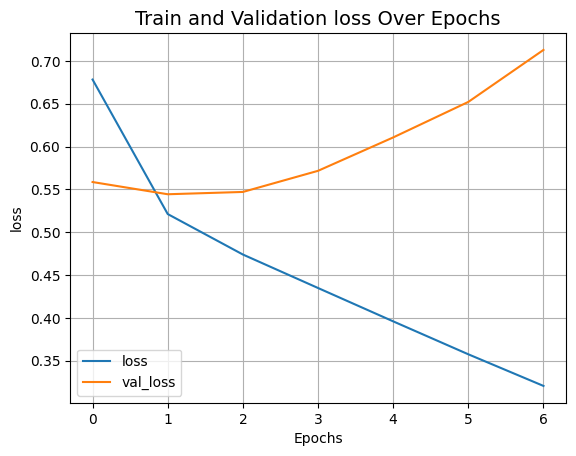

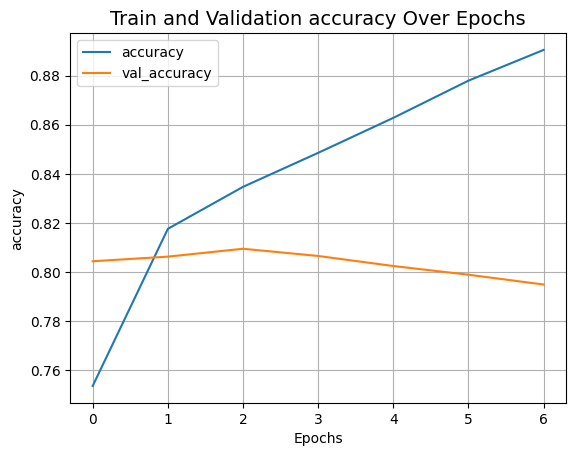

In [34]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [35]:
Xianglin.evaluate(test_dataset, batch_size=BATCH_SIZE)

212/212 ━━━━━━━━━━━━━━━━━━━━ 62s 294ms/step - accuracy: 0.7995 - loss: 0.5890


[0.5778408050537109, 0.8034159541130066]